<a href="https://colab.research.google.com/github/Isyaanggita/SARIMA-vs-Prophet-Comparison/blob/main/sarima-vs-prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast Model Comparison Between SARIMA and Prophet

# Preprocessing

## Import the Necessary Libraries

In [ ]:
# Import Library
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

import time

from google.colab import auth
import gspread
from google.auth import default

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
from pandas.tseries.offsets import DateOffset
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import seaborn as sns
import itertools
from itertools import combinations
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [ ]:
!pip install prophet
import prophet
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

py.init_notebook_mode()

## Importing Data from Google Spreadsheets

In [ ]:
# Connecting to Google Spreadsheets
auth.authenticate_user()

creds, _ = default()
gc = gspread.authorize(creds)

# Open Google Sheets
worksheet = gc.open_by_key('1TLC-f0kA55ZrfNX9er_7bCBJrTc_AIn6viK6esU5WqE')

rows = worksheet.worksheet('Data').get_all_values()

In [ ]:
# Convert to Pandas DataFrame
df = pd.DataFrame.from_records(rows)
df.columns = df.iloc[0]
df = df[1:]
df.head(3)

0 Created Date   Country    City Restaurant ID  \
1   28.02.2020  Portugal  Lisbon          7238   
2   28.02.2020  Portugal  Lisbon         12758   
3   28.02.2020  Portugal  Lisbon          6631   

0                 Restaurant Name Order State Cancel Reason  Cuisine Platform  \
1             Chirashi - Alvalade   delivered                  Sushi      ios   
2  Istanbul Kebab Pizza - Alameda   delivered                  Pizza  android   
3                  A-100 - Lisboa   delivered                Burgers      ios   

0 Payment Method                     Card Issuer Products in Order  \
1       cashless                  BANKINTER S.A.                13   
2       cashless  BANCO COMERCIAL PORTUGUES S.A.                 1   
3       cashless  BANCO COMERCIAL PORTUGUES S.A.                 2   

0 Order Value € (Gross) Delivery Fee Delivery Time  
1                €89.30            0          17.7  
2                €10.00            0          16.3  
3                €16.96            0          13.6

## Data Cleaning


We will tidy up the columns name for easier data processing further.

In [ ]:
# Tidy up Columns Name
df.columns = ['created_date', 'country', 'city', 'restaurant_id', 'restaurant_name', 'order_state',
              'cancel_reason', 'cuisine', 'platform', 'payment_method', 'card_issuer',
              'products_in_order', 'gross_order_value', 'delivery_fee', 'delivery_time']

df.dtypes

created_date         object
country              object
city                 object
restaurant_id        object
restaurant_name      object
order_state          object
cancel_reason        object
cuisine              object
platform             object
payment_method       object
card_issuer          object
products_in_order    object
gross_order_value    object
delivery_fee         object
delivery_time        object
dtype: object

In [ ]:
# Checking Null
df.isna().sum()

created_date         0
country              0
city                 0
restaurant_id        0
restaurant_name      0
order_state          0
cancel_reason        0
cuisine              0
platform             0
payment_method       0
card_issuer          0
products_in_order    0
gross_order_value    0
delivery_fee         0
delivery_time        0
dtype: int64

There are **no null values** because they are considered as whitespace (blank). We are going to **convert blank data into null** for easier data processing.

In [ ]:
# Treat whitespaces as NaN
df = df.replace(r'^\s*$', np.nan, regex=True)
df.head(5)

created_date   country    city restaurant_id  \
1   28.02.2020  Portugal  Lisbon          7238   
2   28.02.2020  Portugal  Lisbon         12758   
3   28.02.2020  Portugal  Lisbon          6631   
4   28.02.2020  Portugal  Lisbon         10535   
5   28.02.2020  Portugal  Lisbon          9695   

                      restaurant_name order_state cancel_reason  \
1                 Chirashi - Alvalade   delivered           NaN   
2      Istanbul Kebab Pizza - Alameda   delivered           NaN   
3                      A-100 - Lisboa   delivered           NaN   
4  La Paparrucha - Parrilla Argentina   delivered           NaN   
5                      Choupana Caffe   delivered           NaN   

          cuisine platform payment_method                     card_issuer  \
1           Sushi      ios       cashless                  BANKINTER S.A.   
2           Pizza  android       cashless  BANCO COMERCIAL PORTUGUES S.A.   
3         Burgers      ios       cashless  BANCO COMERCIAL PORTUGUES S.A.   
4  South American      ios       cashless                   ING BANK N.V.   
5          Brunch      ios       cashless             INTESA SANPAOLO SPA   

  products_in_order gross_order_value delivery_fee delivery_time  
1                13            €89.30            0          17.7  
2                 1            €10.00            0          16.3  
3                 2            €16.96            0          13.6  
4                 3            €25.15          4.2          26.1  
5                 3            €16.00            0          11.6

In [ ]:
# Count total NaN
df.isna().sum()

created_date             0
country                  0
city                     0
restaurant_id            0
restaurant_name          0
order_state              0
cancel_reason        97936
cuisine                327
platform             11934
payment_method           0
card_issuer          12712
products_in_order        0
gross_order_value     1682
delivery_fee          1682
delivery_time         1682
dtype: int64

Now, the **white spaces already convereted into null value**

## Data Formatting

Each columns will be formatted from string / object into correct data types.

In [ ]:
# Format data types for each columns
df['created_date'] = pd.to_datetime(df['created_date'], format='%d.%m.%Y')
df['products_in_order'] = pd.to_numeric(df['products_in_order']).fillna(0).astype(int)
df['gross_order_value'] = pd.to_numeric(df['gross_order_value'].str.replace('€', '')).fillna(0).round(2).astype(float)
df['delivery_fee'] = pd.to_numeric(df['delivery_fee']).fillna(0).round(2).astype(float)
df['delivery_time'] = pd.to_numeric(df['delivery_time']).fillna(0).round(2).astype(float)

df.dtypes

created_date         datetime64[ns]
country                      object
city                         object
restaurant_id                object
restaurant_name              object
order_state                  object
cancel_reason                object
cuisine                      object
platform                     object
payment_method               object
card_issuer                  object
products_in_order             int64
gross_order_value           float64
delivery_fee                float64
delivery_time               float64
dtype: object

In [ ]:
df.head(10)

created_date   country    city restaurant_id  \
1    2020-02-28  Portugal  Lisbon          7238   
2    2020-02-28  Portugal  Lisbon         12758   
3    2020-02-28  Portugal  Lisbon          6631   
4    2020-02-28  Portugal  Lisbon         10535   
5    2020-02-28  Portugal  Lisbon          9695   
6    2020-02-28  Portugal  Lisbon         10181   
7    2020-02-28  Portugal  Lisbon         13475   
8    2020-02-28  Portugal  Lisbon          6735   
9    2020-02-28  Portugal  Lisbon          6632   
10   2020-02-28  Portugal  Lisbon          9603   

                       restaurant_name order_state cancel_reason  \
1                  Chirashi - Alvalade   delivered           NaN   
2       Istanbul Kebab Pizza - Alameda   delivered           NaN   
3                       A-100 - Lisboa   delivered           NaN   
4   La Paparrucha - Parrilla Argentina   delivered           NaN   
5                       Choupana Caffe   delivered           NaN   
6                       Josefino Pizza   delivered           NaN   
7                        Italian Spice   delivered           NaN   
8                          Mano a Mano   delivered           NaN   
9                        A-100 - Algés   delivered           NaN   
10             Churrasqueira Super Rei   delivered           NaN   

           cuisine platform payment_method                     card_issuer  \
1            Sushi      ios       cashless                  BANKINTER S.A.   
2            Pizza  android       cashless  BANCO COMERCIAL PORTUGUES S.A.   
3          Burgers      ios       cashless  BANCO COMERCIAL PORTUGUES S.A.   
4   South American      ios       cashless                   ING BANK N.V.   
5           Brunch      ios       cashless             INTESA SANPAOLO SPA   
6            Pizza  android       cashless                      BANCO BEST   
7          Italian      ios       cashless  CAIXA CENTRAL DE CREDITO AGRIC   
8            Pasta      ios       cashless      BANCO SANTANDER TOTTA S.A.   
9          Burgers  android       cashless                 WIZINK BANK S.A   
10           Grill  android       cashless                  BANKINTER S.A.   

    products_in_order  gross_order_value  delivery_fee  delivery_time  
1                  13              89.30          0.00          17.70  
2                   1              10.00          0.00          16.30  
3                   2              16.96          0.00          13.60  
4                   3              25.15          4.20          26.10  
5                   3              16.00          0.00          11.60  
6                   1              11.50          0.00           8.40  
7                   2               9.68          0.00          30.40  
8                   3              23.80          0.00          23.60  
9                   2              15.92          0.00          30.90  
10                  2              11.30          0.00          22.60

# Exploratory Data Analysis

## Data Information

In [ ]:
df.describe()

products_in_order  gross_order_value  delivery_fee  delivery_time
count           99618.00           99618.00      99618.00       99618.00
mean                2.49              13.11          0.26          16.58
std                 1.96               9.02          0.86          11.94
min                 1.00               0.00          0.00           0.00
25%                 1.00               7.52          0.00          10.60
50%                 2.00              10.50          0.00          14.50
75%                 3.00              16.00          0.00          20.10
max                49.00             135.74         11.98        1174.60

## Relation between order_state and cancel_reason

In [ ]:
df2 = df[['order_state', 'cancel_reason']]
df2.groupby(['order_state', 'cancel_reason'], dropna=False).size()

order_state  cancel_reason                                          
delivered    NaN                                                        97936
failed       Could not find a courier to deliver the order                352
             The restaurant asked customer support to fail the order      301
             User cancellation                                             52
rejected     The restaurant rejected the order                            977
dtype: int64

We conclude that all delivered order_status don't have cancel_reason. For further analysis, we are going to **focus in delivered `order_status`**

In [ ]:
df_delivered = df[df['order_state'] == 'delivered']

## Plot Seasonality Plot

In [ ]:
df_country = df_delivered.groupby(['created_date', 'country'])['products_in_order'].sum().reset_index()

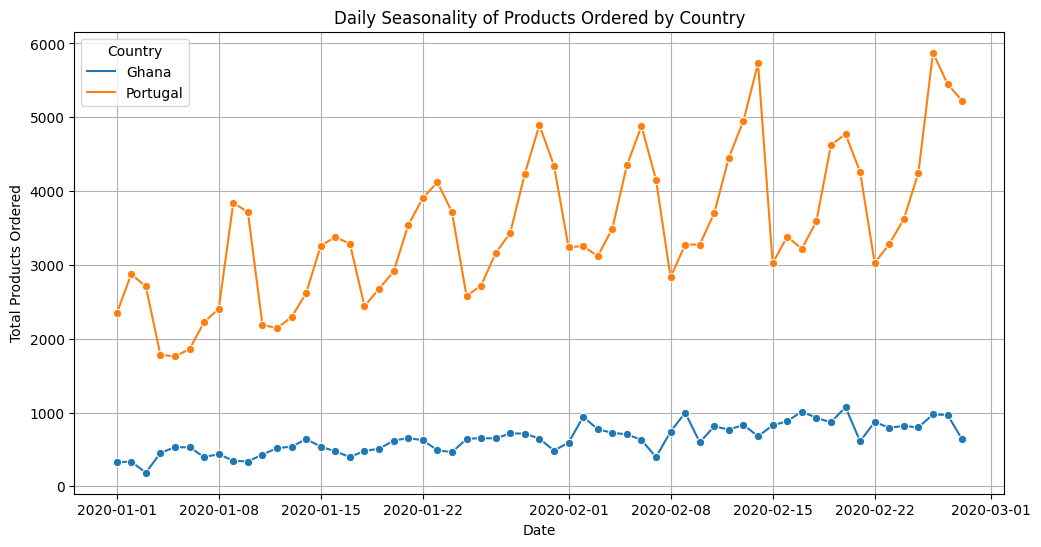

In [ ]:
# Using Seaborn to plot the seasonality for each country
plt.figure(figsize=(12, 6))

sns.lineplot(data = df_country, x = 'created_date', y = 'products_in_order', hue = 'country', marker = 'o')

plt.title('Daily Seasonality of Products Ordered by Country')
plt.xlabel('Date')
plt.ylabel('Total Products Ordered')
plt.legend(title = 'Country')
plt.grid(True)
plt.show()

From the chart above, we can see that there are only 2 countries listed from the data. They are Portugal and Ghana. We are going to separate analysis for those 2 countries.

## Supportive Function

We are going to prepare reusable function for further analysis. The functions are **stationary test** and time **series plot**.

In [ ]:
def test_stationarity(timeseries, window_value, title):
    # Determing rolling statistics
    MA = timeseries.rolling(window=window_value).mean()
    MSTD = timeseries.rolling(window=window_value).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh', title='Time Series Analysis'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('{0}\n Dickey-Fuller: p={1:.5f}'.format(title, p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

A Time Series consists of the following components

- **Trend** : Long term direction of the data.
- **Seasonality** : Short term repetitve patterns of the data due to the weather seasons.
- **Cyclic Variations** : Short term repetitive patterns of the data over a period.
- **Irregularities** : Random and unforseen fluctuations in the data.
---
In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.

# **Portugal Order Forecast (SARIMAX)**

Now wre are goint to visualize the `products_in_order` data for the above components!

Let's use function `seasonal_decompose` from the `statsmodel` library.

---

To use this model, we have to assign model value:

- **Additive Model** : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
- **Multiplicative Model** : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear

## Analyzing Stationary using ADF

Let's filter out Portugal data!

In [ ]:
df_portugal = df_country.loc[df_country['country'] == 'Portugal']
df_portugal = df_portugal[['created_date', 'products_in_order']]
df_portugal = df_portugal.set_index('created_date')
df_portugal

products_in_order
created_date                   
2020-01-01                 2342
2020-01-02                 2874
2020-01-03                 2708
2020-01-04                 1782
2020-01-05                 1759
2020-01-06                 1860
2020-01-07                 2226
2020-01-08                 2402
2020-01-09                 3841
2020-01-10                 3715
2020-01-11                 2189
2020-01-12                 2143
2020-01-13                 2293
2020-01-14                 2618
2020-01-15                 3261
2020-01-16                 3377
2020-01-17                 3286
2020-01-18                 2440
2020-01-19                 2676
2020-01-20                 2911
2020-01-21                 3539
2020-01-22                 3905
2020-01-23                 4120
2020-01-24                 3718
2020-01-25                 2579
2020-01-26                 2719
2020-01-27                 3161
2020-01-28                 3434
2020-01-29                 4235
2020-01-30                 4894
2020-01-31                 4345
2020-02-01                 3239
2020-02-02                 3255
2020-02-03                 3118
2020-02-04                 3490
2020-02-05                 4348
2020-02-06                 4881
2020-02-07                 4153
2020-02-08                 2833
2020-02-09                 3275
2020-02-10                 3276
2020-02-11                 3705
2020-02-12                 4455
2020-02-13                 4954
2020-02-14                 5732
2020-02-15                 3022
2020-02-16                 3384
2020-02-17                 3217
2020-02-18                 3589
2020-02-19                 4624
2020-02-20                 4772
2020-02-21                 4261
2020-02-22                 3026
2020-02-23                 3282
2020-02-24                 3620
2020-02-25                 4248
2020-02-26                 5875
2020-02-27                 5451
2020-02-28                 5224

In [ ]:
df_portugal.describe()

products_in_order
count              59.00
mean             3485.78
std               986.33
min              1759.00
25%              2776.00
50%              3286.00
75%              4194.00
max              5875.00

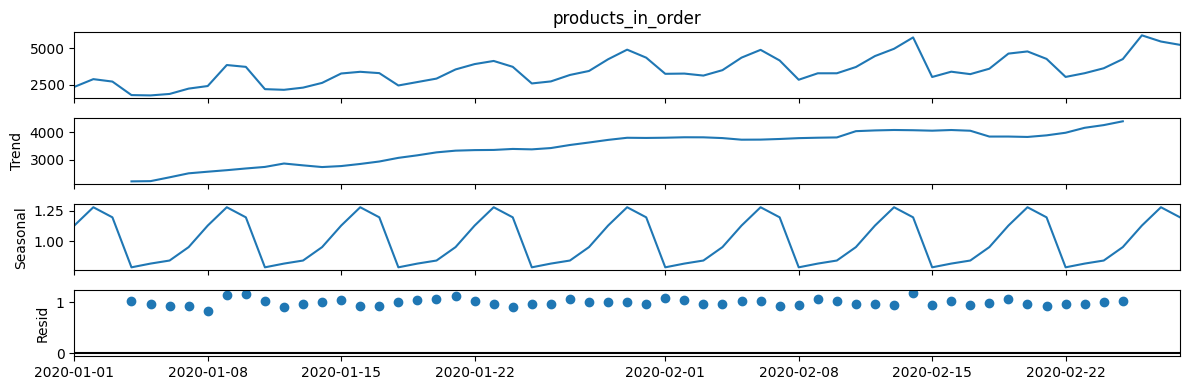

In [ ]:
rcParams["figure.figsize"] = 12, 4
dec = sm.tsa.seasonal_decompose(df_portugal['products_in_order'], period=7, model='multiplicative').plot()
plt.show()

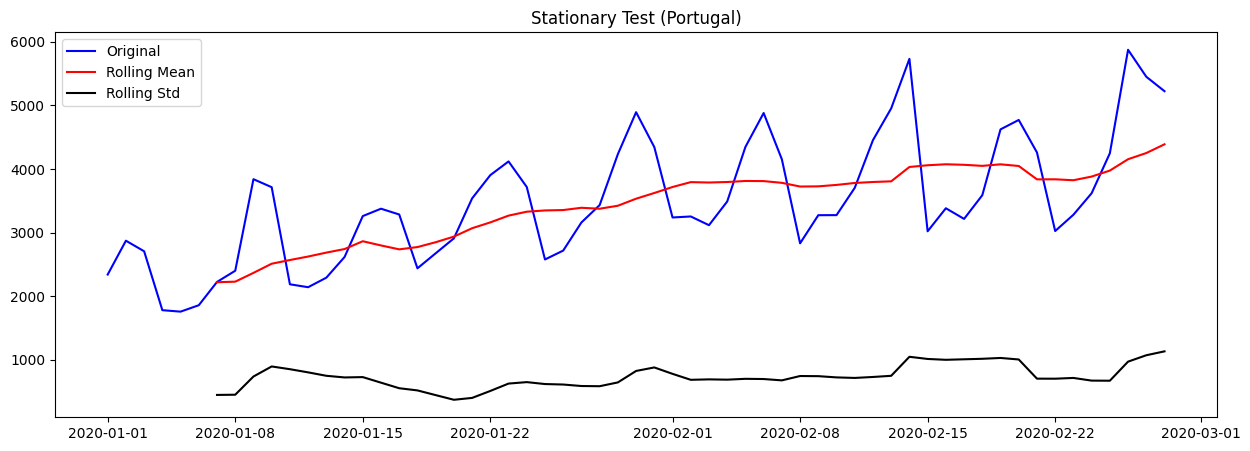

Results of Dickey-Fuller Test:
Test Statistic                -1.52
p-value                        0.52
#Lags Used                    11.00
Number of Observations Used   47.00
Critical Value (1%)           -3.58
Critical Value (5%)           -2.93
Critical Value (10%)          -2.60
dtype: float64


In [ ]:
test_stationarity(df_portugal['products_in_order'], 7, 'Stationary Test (Portugal)')

By using the Augmented Dickey-Fuller, we can see that `p-value` is 0.52, which is **> 0.05**. Hence, **Null Hypotesis** can be rejected.

From both graph and ADF value, we can conclude that the **Portugal data is not stationary**.

Let's do differencing!

---

In [ ]:
df_portugal_diff1 = df_portugal.diff().dropna()

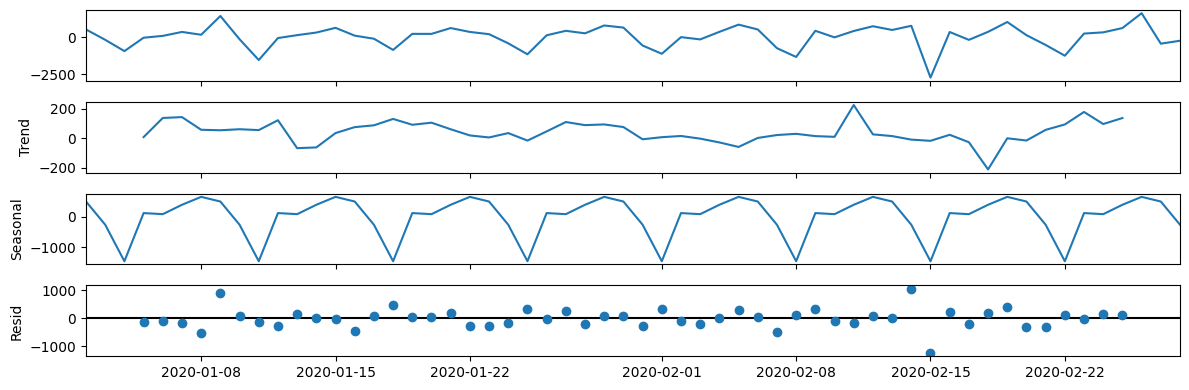

In [ ]:
rcParams["figure.figsize"] = 12, 4
dec = sm.tsa.seasonal_decompose(df_portugal_diff1, period=7).plot()
plt.show()

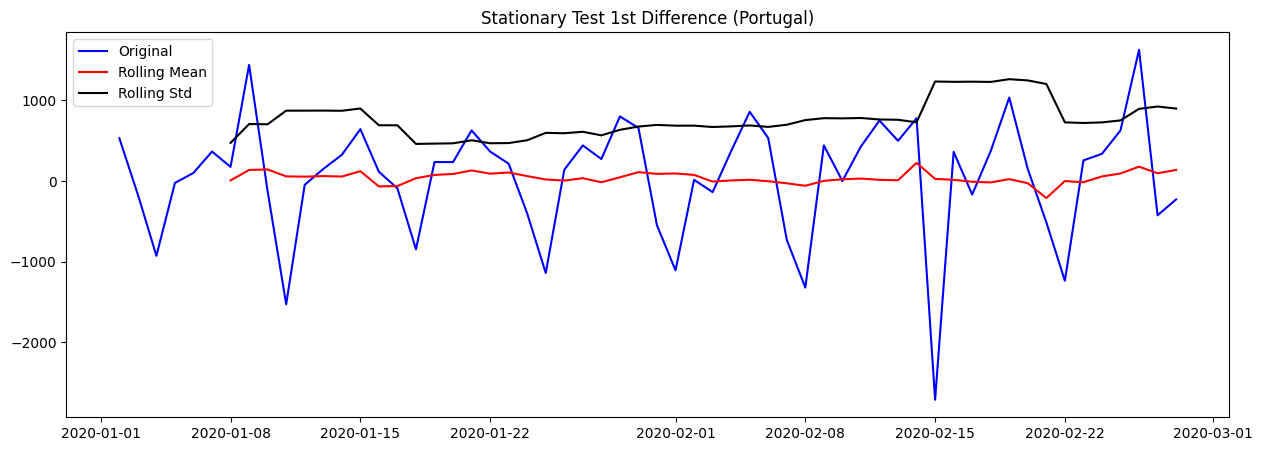

Results of Dickey-Fuller Test:
Test Statistic                -4.03
p-value                        0.00
#Lags Used                     6.00
Number of Observations Used   51.00
Critical Value (1%)           -3.57
Critical Value (5%)           -2.92
Critical Value (10%)          -2.60
dtype: float64


In [ ]:
test_stationarity(df_portugal_diff1, 7, 'Stationary Test 1st Difference (Portugal)')

The result after doing 1st difference is `p-value` **< 0.05** and from the graph shown that the rolling mean is close to zero.

**The data is stationary for the first difference!**

---

## Determining p, d, q for SARIMAX

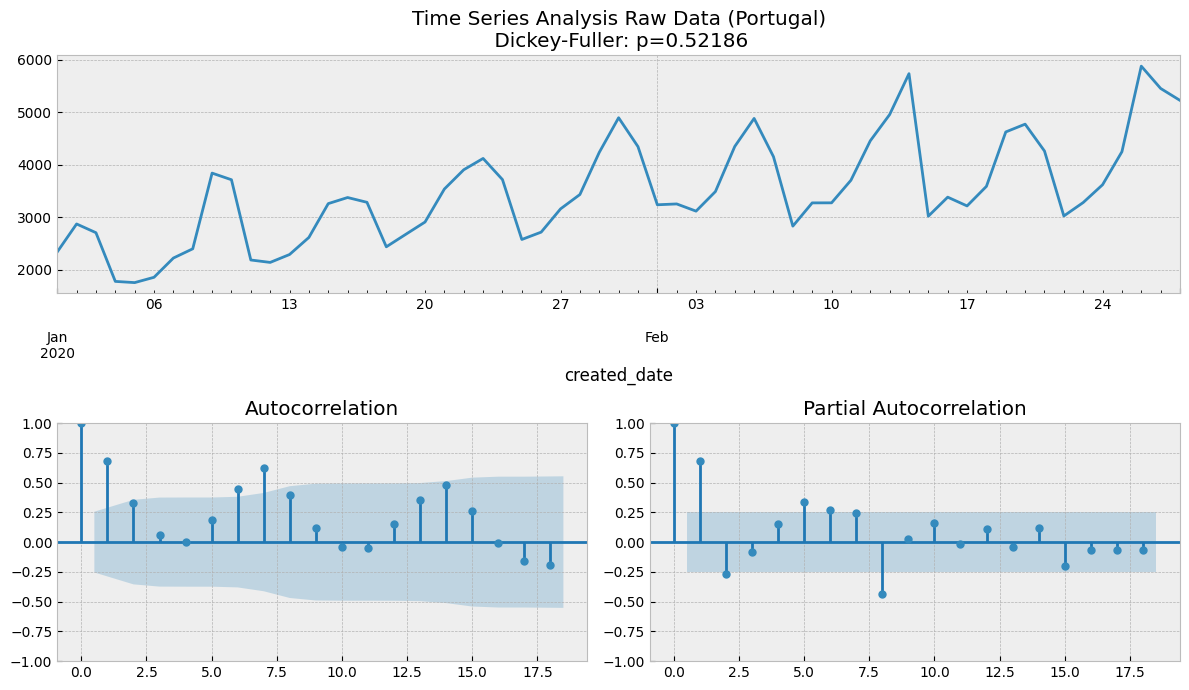

In [ ]:
tsplot(df_portugal['products_in_order'], title='Time Series Analysis Raw Data (Portugal)')

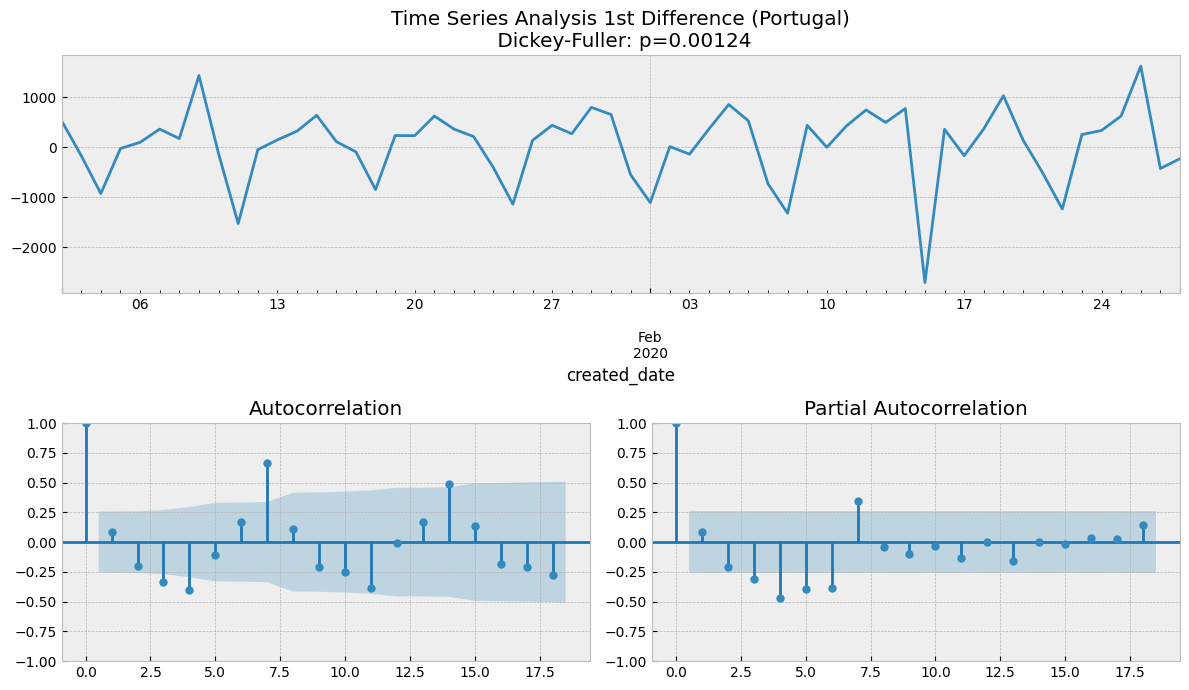

In [ ]:
tsplot(df_portugal_diff1['products_in_order'], title='Time Series Analysis 1st Difference (Portugal)')

From the first difference, we can conclude that `d = 1, p = 5, q = 4`

- d : Number of Differencing
- p : Number of points outside confidence interval from Partial Autocorrelaction
- q : Number of points outside confidence interval from Autocorrelaction

In [ ]:
pdq = (5, 1, 4)

## Determining (P, D, Q, M) for SARIMAX

In [ ]:
data_diff_seas = df_portugal_diff1.diff(7).dropna()

In [ ]:
rcParams["figure.figsize"] = 12, 4
dec = sm.tsa.seasonal_decompose(data_diff_seas, period=7)
plt.show()

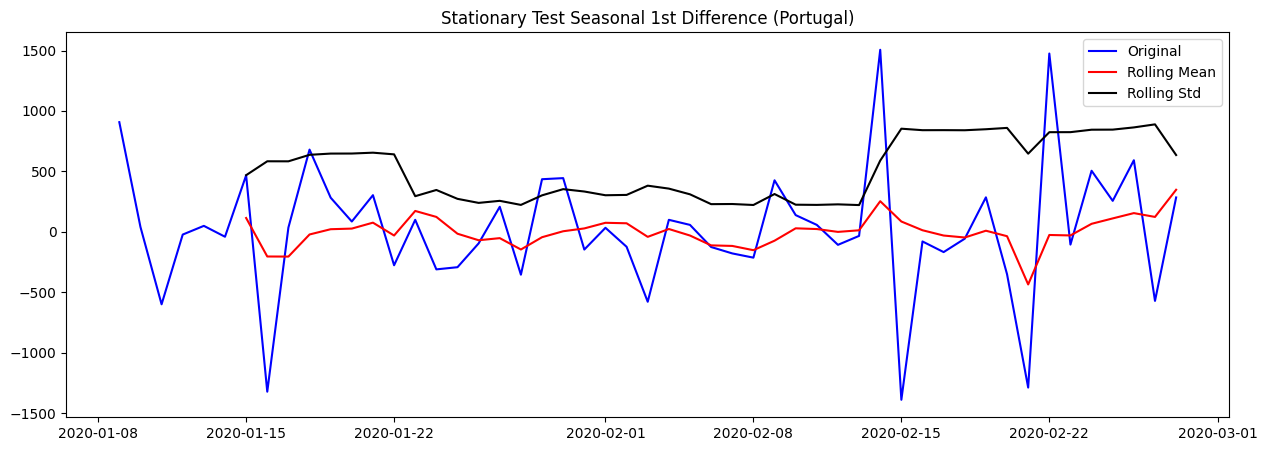

Results of Dickey-Fuller Test:
Test Statistic                -4.85
p-value                        0.00
#Lags Used                    10.00
Number of Observations Used   40.00
Critical Value (1%)           -3.61
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [ ]:
test_stationarity(data_diff_seas['products_in_order'], 7, 'Stationary Test Seasonal 1st Difference (Portugal)')

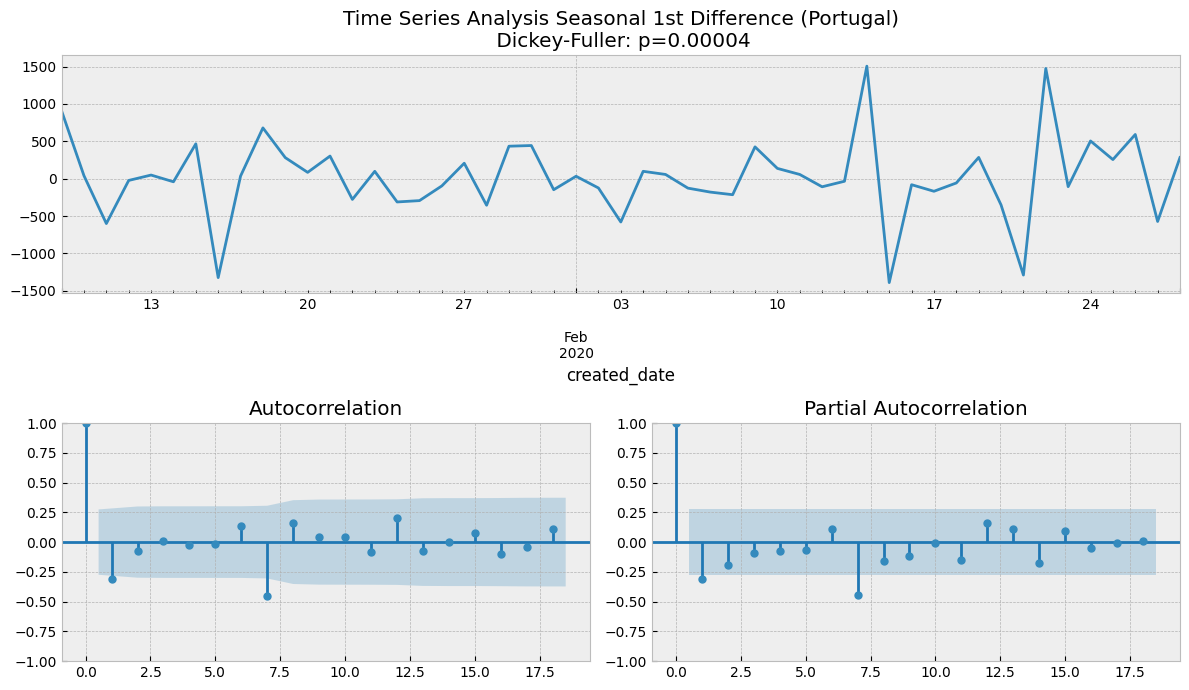

In [ ]:
tsplot(data_diff_seas['products_in_order'], title='Time Series Analysis Seasonal 1st Difference (Portugal)')

Let's determine Seasonal Order `p, d, q, m`. With the same method, we can determine that `d = 1, p = 2, q = 2, m = 7`.

- d : Number of Differencing
- p : Number of points outside confidence interval from Partial Autocorrelaction
- q : Number of points outside confidence interval from Autocorrelaction
- m : Seasonality Interval

In [ ]:
pdqm = (2, 1, 2, 7)

## Train SARIMAX

Let's use rolling forecast method where we predict or forecast a single value and use this predicted value again for model fitting for predicting the next value.

In [ ]:
model = sm.tsa.statespace.SARIMAX(df_portugal['products_in_order'], order=pdq, seasonal_order=pdqm)
model_fit = model.fit()
print(model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                      products_in_order   No. Observations:                   59
Model:             SARIMAX(5, 1, 4)x(2, 1, [1, 2], 7)   Log Likelihood                -376.022
Date:                                Wed, 20 Dec 2023   AIC                            780.044
Time:                                        07:14:45   BIC                            807.090
Sample:                                    01-01-2020   HQIC                           790.379
                                         - 02-28-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4569      1.146     -0.399      0.690      -2.702       1.788
ar.

In [ ]:
# Set Training
size = int(len(df_portugal) * 0.6)
train, test = df_portugal['products_in_order'][0:size], df_portugal['products_in_order'][size:len(df_portugal)]

print('\t SARIMAX MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

start = time.time()

for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=pdqm)
    model_fit = model.fit()

    output = model_fit.forecast()

    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

sarimax_portugal_training_time = time.time() - start
print('SARIMAX training time: %.3f s' % sarimax_portugal_training_time)

	 SARIMAX MODEL : In - Sample Forecasting 

predicted = 4326.285529, expected = 4348.000000
predicted = 5167.718454, expected = 4881.000000
predicted = 4778.121721, expected = 4153.000000
predicted = 3489.961061, expected = 2833.000000
predicted = 3174.001748, expected = 3275.000000
predicted = 3571.254554, expected = 3276.000000
predicted = 3744.078719, expected = 3705.000000
predicted = 4581.551716, expected = 4455.000000
predicted = 4669.907576, expected = 4954.000000
predicted = 4353.712600, expected = 5732.000000
predicted = 4682.475659, expected = 3022.000000
predicted = 3355.867235, expected = 3384.000000
predicted = 3662.085777, expected = 3217.000000
predicted = 3501.261472, expected = 3589.000000
predicted = 4769.606350, expected = 4624.000000
predicted = 4979.360092, expected = 4772.000000
predicted = 4859.084432, expected = 4261.000000
predicted = 3045.507247, expected = 3026.000000
predicted = 3277.578584, expected = 3282.000000
predicted = 3248.631594, expected = 3620.000

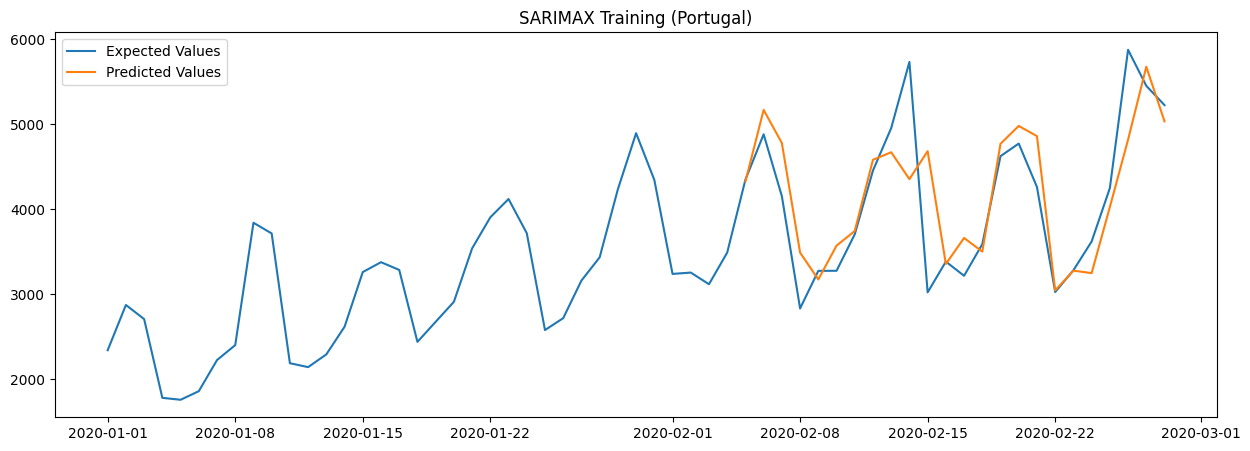

In [ ]:
predictions_series = pd.Series(predictions, index=test.index)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

plt.subplot(1, 1, 1)
plt.title('SARIMAX Training (Portugal)')
plt.plot(df_portugal['products_in_order'], label='Expected Values')
plt.plot(predictions_series, label='Predicted Values')
plt.legend(loc="upper left")
plt.show()

In [ ]:
rmse_sarimax_portugal = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.4f' % rmse_sarimax_portugal)

Test RMSE: 569.2641


Looks like the result for SARIMAX is quite close to the real data, but the RSME is quite high.

## March 2020 Forecast

Let's predict for the next 33 days from today (until end March 2020)

In [ ]:
future_dates = [df_portugal.index[-1] + DateOffset(days=x) for x in range(0, 33)]

# New dataframe for storing the future values
df3 = pd.DataFrame(index=future_dates[1:], columns=df_portugal.columns)

forecast = pd.concat([df_portugal, df3])
forecast['SARIMAX_Forecast'] = np.NaN
forecast.tail(40)

products_in_order  SARIMAX_Forecast
2020-02-21              4261               NaN
2020-02-22              3026               NaN
2020-02-23              3282               NaN
2020-02-24              3620               NaN
2020-02-25              4248               NaN
2020-02-26              5875               NaN
2020-02-27              5451               NaN
2020-02-28              5224               NaN
2020-02-29               NaN               NaN
2020-03-01               NaN               NaN
2020-03-02               NaN               NaN
2020-03-03               NaN               NaN
2020-03-04               NaN               NaN
2020-03-05               NaN               NaN
2020-03-06               NaN               NaN
2020-03-07               NaN               NaN
2020-03-08               NaN               NaN
2020-03-09               NaN               NaN
2020-03-10               NaN               NaN
2020-03-11               NaN               NaN
2020-03-12               NaN               NaN
2020-03-13               NaN               NaN
2020-03-14               NaN               NaN
2020-03-15               NaN               NaN
2020-03-16               NaN               NaN
2020-03-17               NaN               NaN
2020-03-18               NaN               NaN
2020-03-19               NaN               NaN
2020-03-20               NaN               NaN
2020-03-21               NaN               NaN
2020-03-22               NaN               NaN
2020-03-23               NaN               NaN
2020-03-24               NaN               NaN
2020-03-25               NaN               NaN
2020-03-26               NaN               NaN
2020-03-27               NaN               NaN
2020-03-28               NaN               NaN
2020-03-29               NaN               NaN
2020-03-30               NaN               NaN
2020-03-31               NaN               NaN

SARIMAX forecast time: 86.459 s


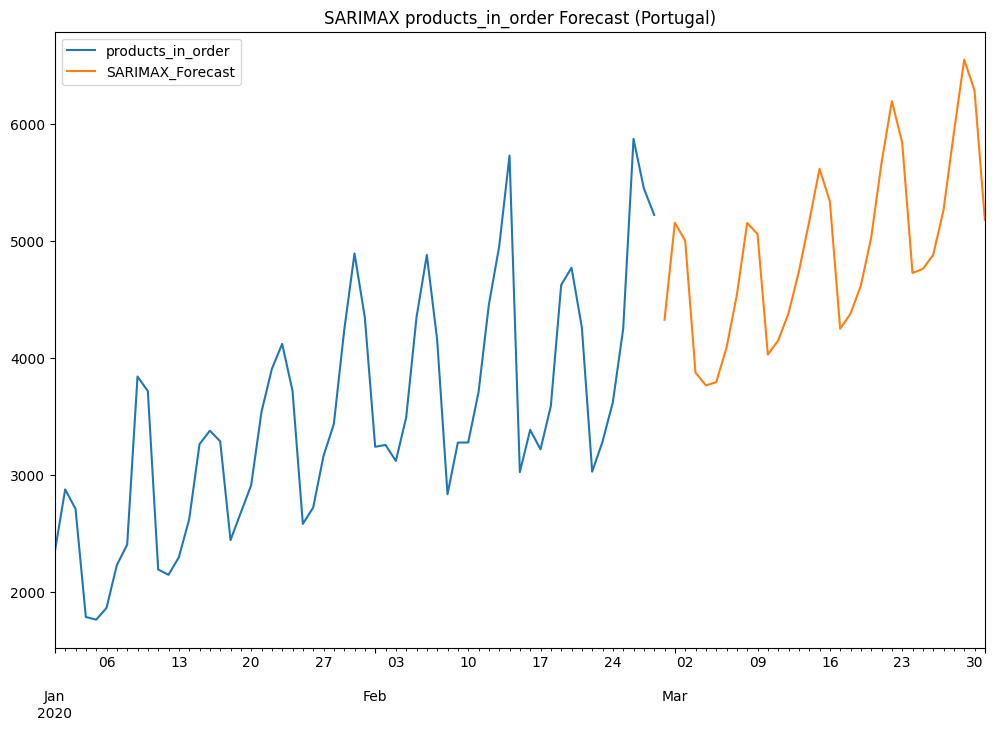

In [ ]:
SARIMAX_history_f = [x for x in train]
f1 = []

start = time.time()

for t in (range(len(df3))):
    model = sm.tsa.statespace.SARIMAX(SARIMAX_history_f, order=pdq, seasonal_order=pdqm)
    model_fit = model.fit()

    output = model_fit.forecast()[0]

    SARIMAX_history_f.append(output)
    f1.append(output)

for i in range(len(f1)):
    forecast.iloc[len(df_portugal) + i, 1] = f1[i]

sarimax_portugal_forecast_time = time.time() - start
print('SARIMAX forecast time: %.3f s' % sarimax_portugal_forecast_time)

forecast[['products_in_order', 'SARIMAX_Forecast']].plot(figsize=(12, 8), title='SARIMAX products_in_order Forecast (Portugal)');

Save `forecast_sarimax_portugal` for further use

In [ ]:
forecast_sarimax_portugal = forecast[['SARIMAX_Forecast']]
forecast_sarimax_portugal.index.name = 'created_date'
forecast_sarimax_portugal

SARIMAX_Forecast
created_date                  
2020-01-01                 NaN
2020-01-02                 NaN
2020-01-03                 NaN
2020-01-04                 NaN
2020-01-05                 NaN
...                        ...
2020-03-27             5266.37
2020-03-28             5926.49
2020-03-29             6552.94
2020-03-30             6289.53
2020-03-31             5182.86

[91 rows x 1 columns]

In [ ]:
forecast_summary = forecast_sarimax_portugal.groupby(forecast.index.month).sum()
forecast_summary.index.name = 'month'
forecast_summary

SARIMAX_Forecast
month                  
1                  0.00
2               4326.29
3             153427.90

# **Ghana Order Forecast (SARIMAX)**

Let's do the same with Ghana Data!

## Analyzing Stationary using ADF

In [ ]:
df_ghana = df_country.loc[df_country['country'] == 'Ghana']
df_ghana = df_ghana[['created_date', 'products_in_order']]
df_ghana = df_ghana.set_index('created_date')
df_ghana.head(10)

products_in_order
created_date                   
2020-01-01                  327
2020-01-02                  334
2020-01-03                  184
2020-01-04                  452
2020-01-05                  530
2020-01-06                  528
2020-01-07                  397
2020-01-08                  435
2020-01-09                  346
2020-01-10                  336

In [ ]:
df_ghana.describe()

products_in_order
count              59.00
mean              643.73
std               201.45
min               184.00
25%               486.50
50%               639.00
75%               797.00
max              1073.00

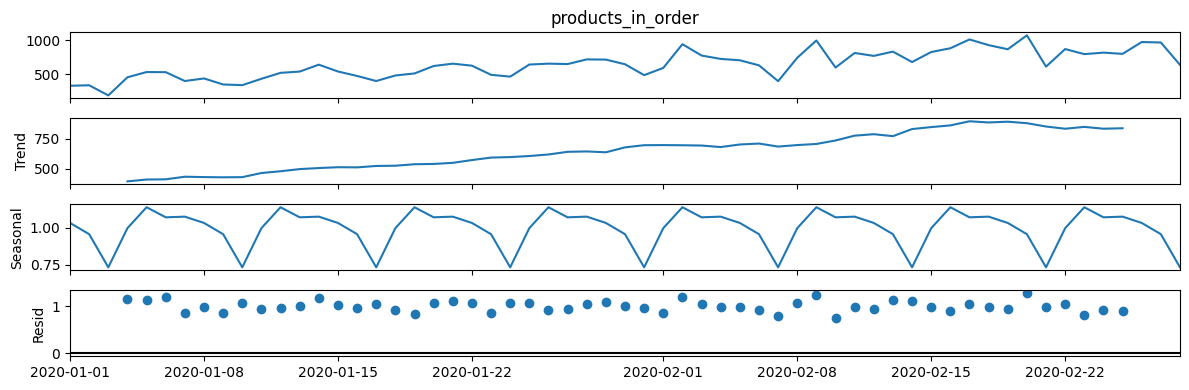

In [ ]:
dec = sm.tsa.seasonal_decompose(df_ghana['products_in_order'], period=7, model='multiplicative').plot()
rcParams["figure.figsize"] = 12, 4
plt.show()

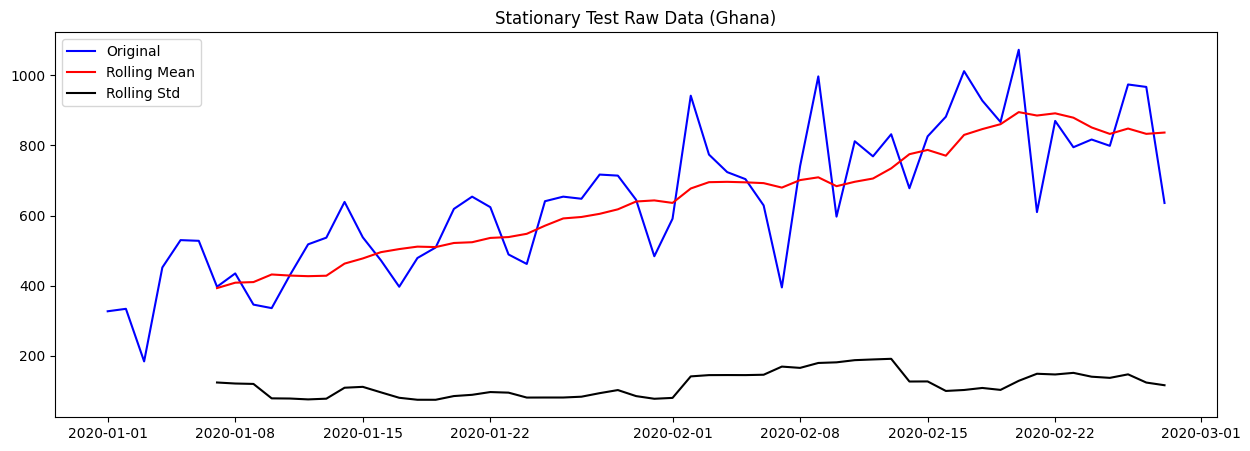

Results of Dickey-Fuller Test:
Test Statistic                -1.13
p-value                        0.70
#Lags Used                     6.00
Number of Observations Used   52.00
Critical Value (1%)           -3.56
Critical Value (5%)           -2.92
Critical Value (10%)          -2.60
dtype: float64


In [ ]:
test_stationarity(df_ghana['products_in_order'], 7, 'Stationary Test Raw Data (Ghana)')

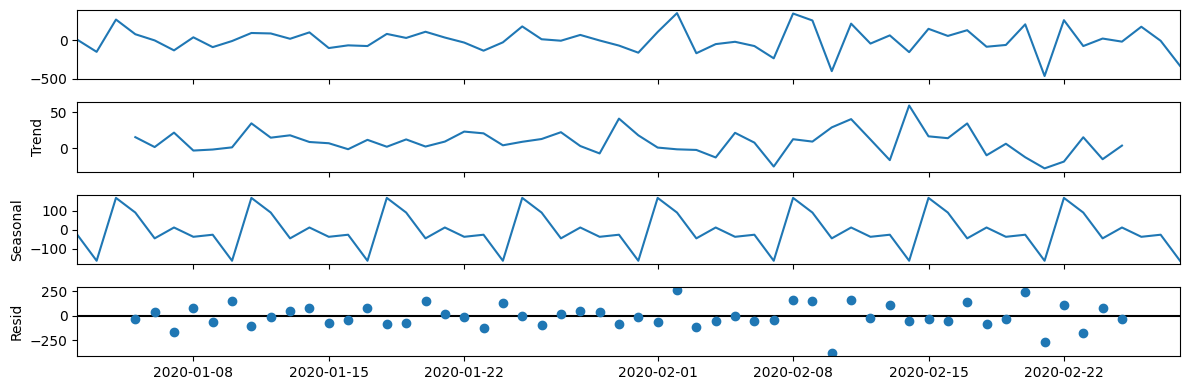

In [ ]:
df_ghana_diff1 = df_ghana.diff().dropna()
dec = sm.tsa.seasonal_decompose(df_ghana_diff1, period=7).plot()
rcParams["figure.figsize"] = 12, 4
plt.show()

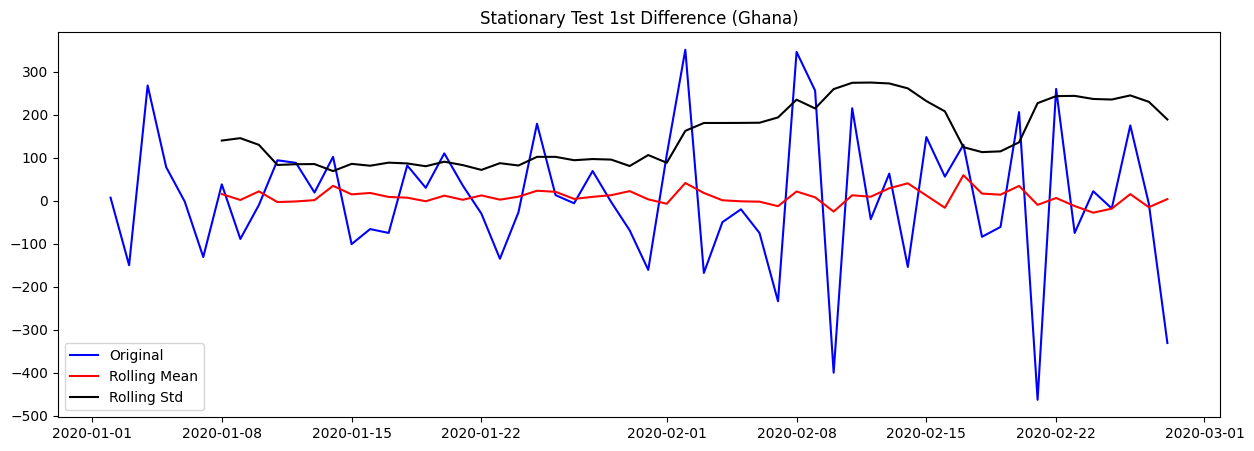

Results of Dickey-Fuller Test:
Test Statistic                -8.75
p-value                        0.00
#Lags Used                     5.00
Number of Observations Used   52.00
Critical Value (1%)           -3.56
Critical Value (5%)           -2.92
Critical Value (10%)          -2.60
dtype: float64


In [ ]:
test_stationarity(df_ghana_diff1, 7, 'Stationary Test 1st Difference (Ghana)')

Looks like the Ghana data has similar characteristics with Portugal, they need the 1st difference to get `p-value` < **0.05**

## Determining p, d, q for SARIMAX

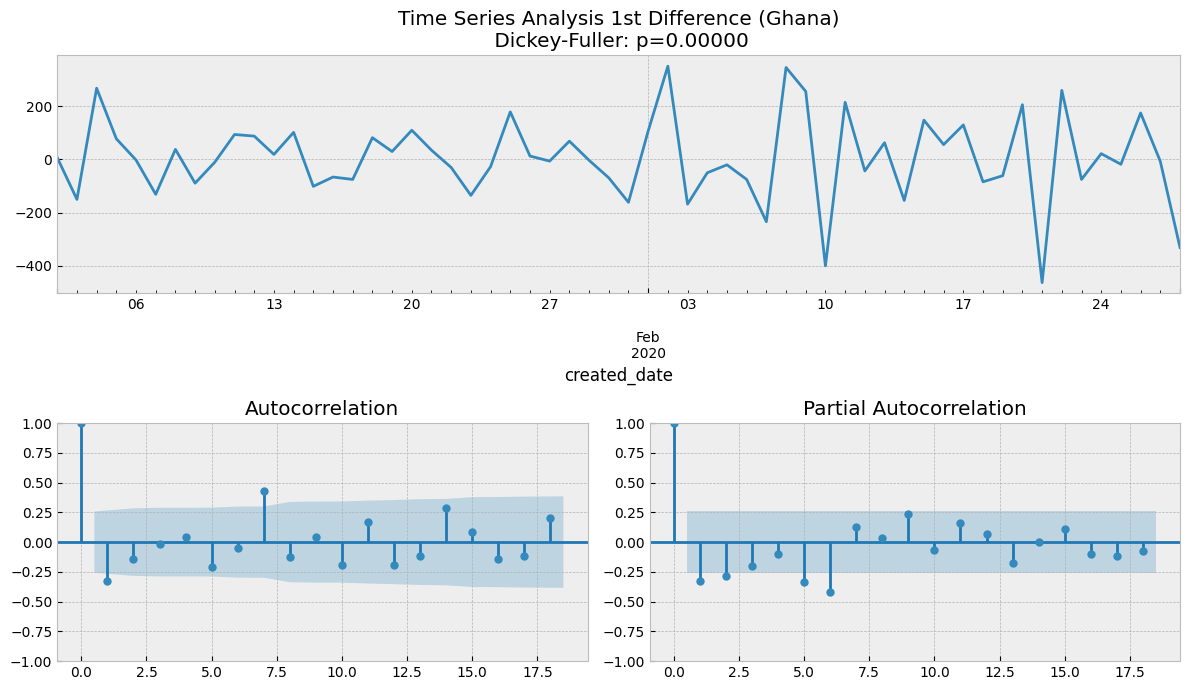

In [ ]:
tsplot(df_ghana_diff1['products_in_order'], title='Time Series Analysis 1st Difference (Ghana)')

From the first difference, we can conclude that `d = 1, p = 4, q = 2`

- d : Number of Differencing
- p : Number of points outside confidence interval from Partial Autocorrelaction
- q : Number of points outside confidence interval from Autocorrelaction

In [ ]:
pdq = (4, 1, 2)

## Determining (P, D, Q, M) for SARIMAX

In [ ]:
data_diff_seas = df_ghana_diff1.diff(7).dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas, period = 7)
rcParams["figure.figsize"] = 12, 4
plt.show()

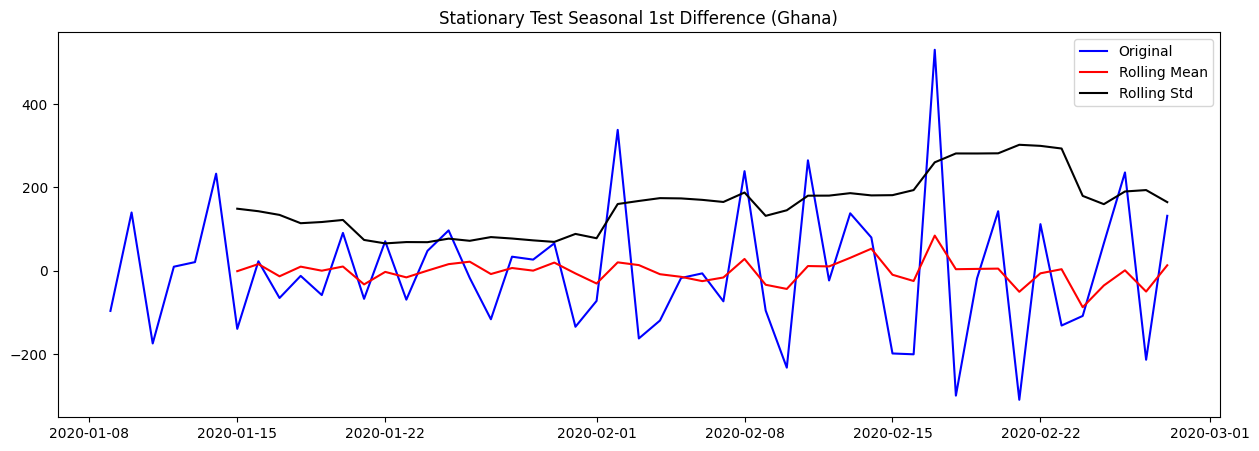

Results of Dickey-Fuller Test:
Test Statistic                -3.01
p-value                        0.03
#Lags Used                     9.00
Number of Observations Used   41.00
Critical Value (1%)           -3.60
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [ ]:
test_stationarity(data_diff_seas['products_in_order'], 7, 'Stationary Test Seasonal 1st Difference (Ghana)')

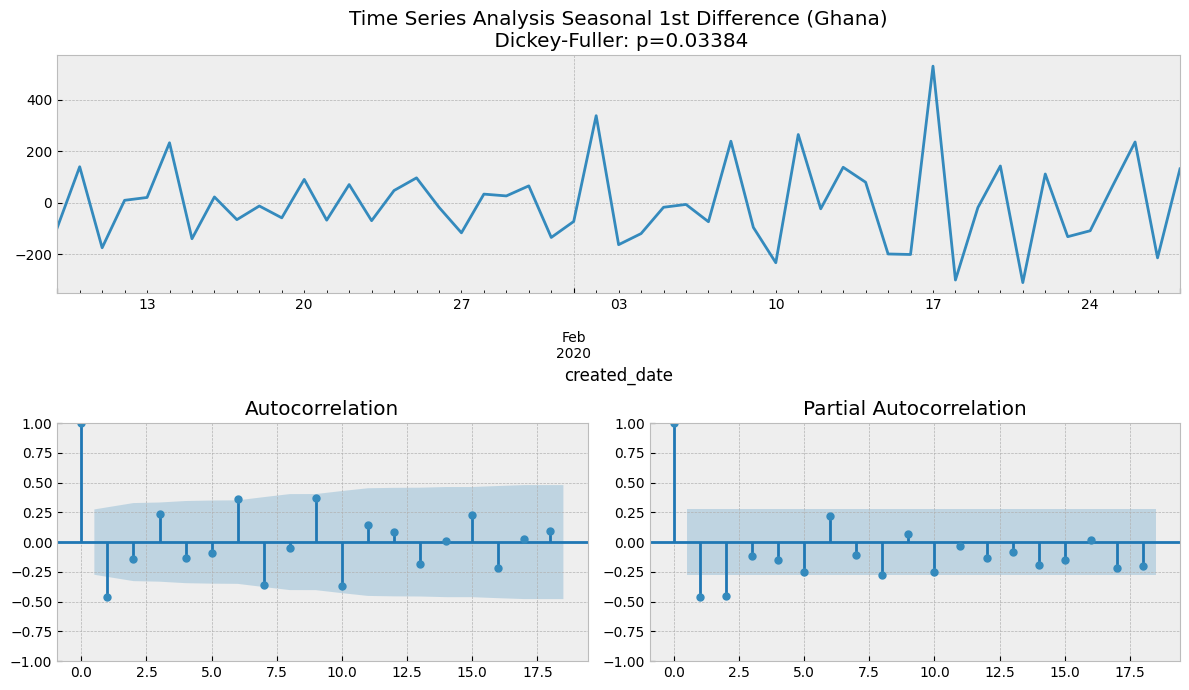

In [ ]:
tsplot(data_diff_seas['products_in_order'], title='Time Series Analysis Seasonal 1st Difference (Ghana)')

Let's determine Seasonal Order `p, d, q, m`. With the same method, we can determine that `d = 1, p = 2, q = 1, m = 7`.

- d : Number of Differencing
- p : Number of points outside confidence interval from Partial Autocorrelaction
- q : Number of points outside confidence interval from Autocorrelaction
- m : Seasonality Interval

In [ ]:
pdqm = (2,1,1,7)

## Train SARIMAX

In [ ]:
# Set Training
size = int(len(df_ghana) * 0.6)
train, test = df_ghana['products_in_order'][0:size], df_ghana['products_in_order'][size:len(df_ghana)]

print('\t SARIMAX MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

start = time.time()

for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=pdqm)
    model_fit = model.fit()

    output = model_fit.forecast()

    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

sarimax_ghana_training_time = time.time() - start
print('SARIMAX training time: %.3f s' % sarimax_ghana_training_time)

	 SARIMAX MODEL : In - Sample Forecasting 

predicted = 715.399775, expected = 704.000000
predicted = 758.994481, expected = 629.000000
predicted = 618.214788, expected = 395.000000
predicted = 678.555050, expected = 741.000000
predicted = 997.190753, expected = 997.000000
predicted = 846.565291, expected = 597.000000
predicted = 714.095050, expected = 812.000000
predicted = 867.410653, expected = 769.000000
predicted = 687.455771, expected = 832.000000
predicted = 446.248093, expected = 678.000000
predicted = 765.181527, expected = 826.000000
predicted = 1046.050404, expected = 882.000000
predicted = 824.581986, expected = 1012.000000
predicted = 893.639741, expected = 928.000000
predicted = 852.719786, expected = 867.000000
predicted = 795.609785, expected = 1073.000000
predicted = 810.996297, expected = 610.000000
predicted = 861.216963, expected = 870.000000
predicted = 1049.375346, expected = 795.000000
predicted = 1039.314845, expected = 817.000000
predicted = 990.381936, expecte

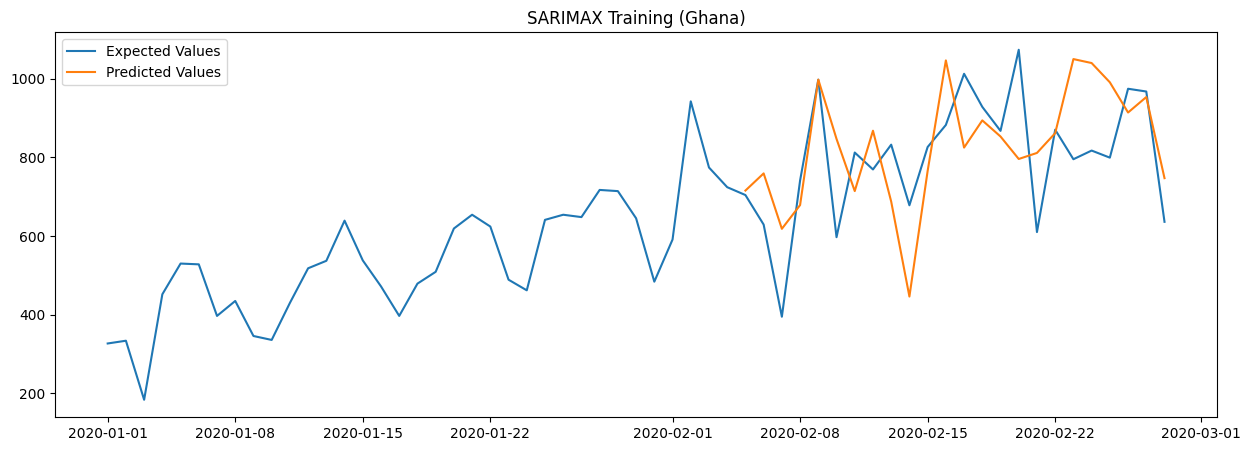

In [ ]:
predictions_series = pd.Series(predictions, index=test.index)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

plt.subplot(1, 1, 1)
plt.title('SARIMAX Training (Ghana)')
plt.plot(df_ghana['products_in_order'], label='Expected Values')
plt.plot(predictions_series, label='Predicted Values')
plt.legend(loc="upper left")
plt.show()

In [ ]:
rmse_sarimax_ghana = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.4f' % rmse_sarimax_ghana)

Test RMSE: 155.2347


Ghana data has higher noise, however the RSME is lower than Portugal.

## March 2020 Forecast

Let's predict until the end of March 2020!

In [ ]:
future_dates = [df_ghana.index[-1] + DateOffset(days=x) for x in range(0, 33)]

# New dataframe for storing the future values
df3 = pd.DataFrame(index=future_dates[1:], columns=df_ghana.columns)

forecast = pd.concat([df_ghana, df3])
forecast['SARIMAX_Forecast'] = np.NaN
forecast.tail(40)

products_in_order  SARIMAX_Forecast
2020-02-21               610               NaN
2020-02-22               870               NaN
2020-02-23               795               NaN
2020-02-24               817               NaN
2020-02-25               799               NaN
2020-02-26               974               NaN
2020-02-27               967               NaN
2020-02-28               636               NaN
2020-02-29               NaN               NaN
2020-03-01               NaN               NaN
2020-03-02               NaN               NaN
2020-03-03               NaN               NaN
2020-03-04               NaN               NaN
2020-03-05               NaN               NaN
2020-03-06               NaN               NaN
2020-03-07               NaN               NaN
2020-03-08               NaN               NaN
2020-03-09               NaN               NaN
2020-03-10               NaN               NaN
2020-03-11               NaN               NaN
2020-03-12               NaN               NaN
2020-03-13               NaN               NaN
2020-03-14               NaN               NaN
2020-03-15               NaN               NaN
2020-03-16               NaN               NaN
2020-03-17               NaN               NaN
2020-03-18               NaN               NaN
2020-03-19               NaN               NaN
2020-03-20               NaN               NaN
2020-03-21               NaN               NaN
2020-03-22               NaN               NaN
2020-03-23               NaN               NaN
2020-03-24               NaN               NaN
2020-03-25               NaN               NaN
2020-03-26               NaN               NaN
2020-03-27               NaN               NaN
2020-03-28               NaN               NaN
2020-03-29               NaN               NaN
2020-03-30               NaN               NaN
2020-03-31               NaN               NaN

SARIMAX forecast time: 58.206 s


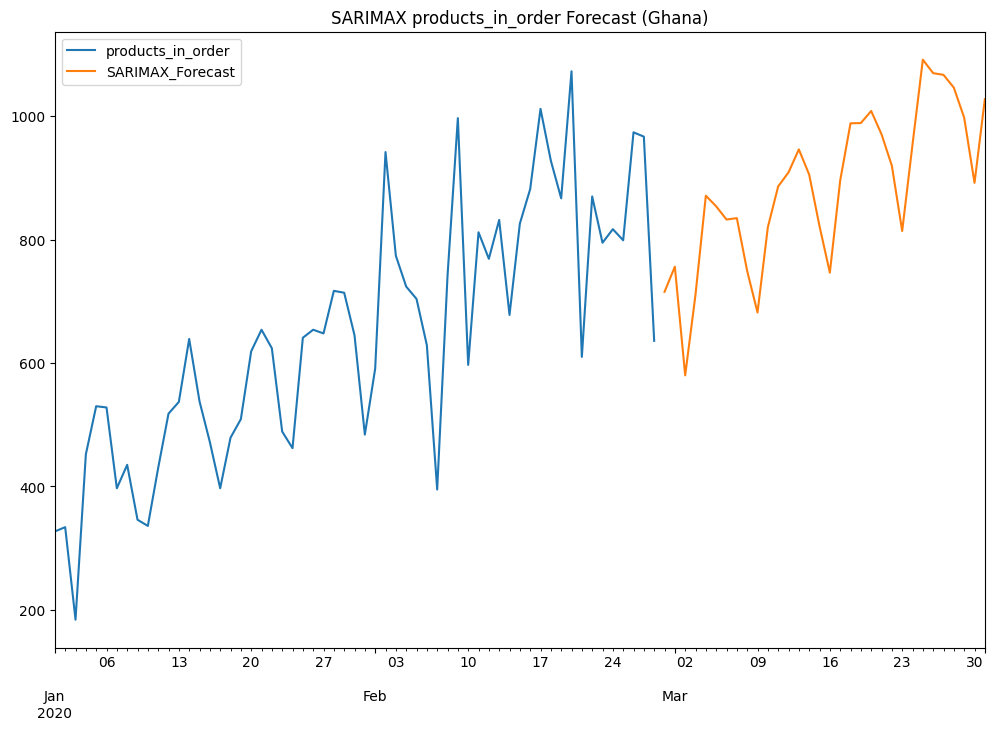

In [ ]:
SARIMAX_history_f = [x for x in train]
f1 = []

start = time.time()

for t in (range(len(df3))):
    model = sm.tsa.statespace.SARIMAX(SARIMAX_history_f, order=pdq, seasonal_order=pdqm)
    model_fit = model.fit()

    output = model_fit.forecast()[0]

    SARIMAX_history_f.append(output)
    f1.append(output)

for i in range(len(f1)):
    forecast.iloc[len(df_ghana) + i, 1] = f1[i]

sarimax_ghana_forecast_time = time.time() - start
print('SARIMAX forecast time: %.3f s' % sarimax_ghana_forecast_time)

forecast[['products_in_order', 'SARIMAX_Forecast']].plot(figsize=(12, 8), title='SARIMAX products_in_order Forecast (Ghana)');

Save `forecast_sarimax_ghana` for further use

In [ ]:
forecast_sarimax_ghana = forecast[['SARIMAX_Forecast']]
forecast_sarimax_ghana.index.name = 'created_date'
forecast_sarimax_ghana

SARIMAX_Forecast
created_date                  
2020-01-01                 NaN
2020-01-02                 NaN
2020-01-03                 NaN
2020-01-04                 NaN
2020-01-05                 NaN
...                        ...
2020-03-27             1067.15
2020-03-28             1046.41
2020-03-29              997.72
2020-03-30              892.11
2020-03-31             1027.69

[91 rows x 1 columns]

In [ ]:
forecast_summary = forecast_sarimax_ghana.groupby(forecast.index.month).sum()
forecast_summary.index.name = 'month'
forecast_summary

SARIMAX_Forecast
month                  
1                  0.00
2                715.40
3              27641.09

# Portugal Order Forecast (Facebook Prophet)

## Data Preparation

Let's try Facebook Prophet modelling! It works best with time series that have strong seasonal effects and several seasons of historical data.

In [ ]:
my_model = Prophet(interval_width=0.95)

Prophet needs to convert data frame into `ds` and `y`

In [ ]:
df_pr = df_portugal.reset_index()
df_pr.columns = ['ds', 'y']
df_pr

ds     y
0  2020-01-01  2342
1  2020-01-02  2874
2  2020-01-03  2708
3  2020-01-04  1782
4  2020-01-05  1759
5  2020-01-06  1860
6  2020-01-07  2226
7  2020-01-08  2402
8  2020-01-09  3841
9  2020-01-10  3715
10 2020-01-11  2189
11 2020-01-12  2143
12 2020-01-13  2293
13 2020-01-14  2618
14 2020-01-15  3261
15 2020-01-16  3377
16 2020-01-17  3286
17 2020-01-18  2440
18 2020-01-19  2676
19 2020-01-20  2911
20 2020-01-21  3539
21 2020-01-22  3905
22 2020-01-23  4120
23 2020-01-24  3718
24 2020-01-25  2579
25 2020-01-26  2719
26 2020-01-27  3161
27 2020-01-28  3434
28 2020-01-29  4235
29 2020-01-30  4894
30 2020-01-31  4345
31 2020-02-01  3239
32 2020-02-02  3255
33 2020-02-03  3118
34 2020-02-04  3490
35 2020-02-05  4348
36 2020-02-06  4881
37 2020-02-07  4153
38 2020-02-08  2833
39 2020-02-09  3275
40 2020-02-10  3276
41 2020-02-11  3705
42 2020-02-12  4455
43 2020-02-13  4954
44 2020-02-14  5732
45 2020-02-15  3022
46 2020-02-16  3384
47 2020-02-17  3217
48 2020-02-18  3589
49 2020-02-19  4624
50 2020-02-20  4772
51 2020-02-21  4261
52 2020-02-22  3026
53 2020-02-23  3282
54 2020-02-24  3620
55 2020-02-25  4248
56 2020-02-26  5875
57 2020-02-27  5451
58 2020-02-28  5224

In [ ]:
start = time.time()

m = Prophet()
m.fit(df_pr)

prophet_portugal_training_time = time.time() - start
print('Prophet training time: %.3f s' % prophet_portugal_training_time)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3g77__w3/143wzj1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3g77__w3/yswvpfjo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60766', 'data', 'file=/tmp/tmp3g77__w3/143wzj1g.json', 'init=/tmp/tmp3g77__w3/yswvpfjo.json', 'output', 'file=/tmp/tmp3g77__w3/prophet_model8weiwfi_/prophet_model-20231220071910.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:19:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:19:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet training time: 0.293 s


## March 2020 Forecast

In [ ]:
future = m.make_future_dataframe(periods=32)

start = time.time()

prophet_pred = m.predict(future)

prophet_portugal_forecast_time = time.time() - start
print('Prophet forecast time: %.3f s' % prophet_portugal_forecast_time)

prophet_pred = pd.DataFrame({"created_date" : prophet_pred['ds'], "Prophet_Forecast" : prophet_pred["yhat"]})
prophet_pred = prophet_pred.set_index("created_date")
prophet_pred

Prophet forecast time: 0.062 s


Prophet_Forecast
created_date                  
2020-01-01             2760.96
2020-01-02             3182.24
2020-01-03             2965.88
2020-01-04             1607.59
2020-01-05             1787.98
...                        ...
2020-03-27             5983.38
2020-03-28             4610.18
2020-03-29             4775.66
2020-03-30             4888.63
2020-03-31             5305.36

[91 rows x 1 columns]

In [ ]:
forecast_summary = prophet_pred.groupby(forecast.index.month).sum()
forecast_summary.index.name = 'month'
forecast_summary

Prophet_Forecast
month                  
1              92601.43
2             116792.13
3             153470.70

In [ ]:
forecast = prophet_pred.join(df_portugal).join(forecast_sarimax_portugal)
forecast

Prophet_Forecast  products_in_order  SARIMAX_Forecast
created_date                                                       
2020-01-01             2760.96            2342.00               NaN
2020-01-02             3182.24            2874.00               NaN
2020-01-03             2965.88            2708.00               NaN
2020-01-04             1607.59            1782.00               NaN
2020-01-05             1787.98            1759.00               NaN
...                        ...                ...               ...
2020-03-27             5983.38                NaN           5266.37
2020-03-28             4610.18                NaN           5926.49
2020-03-29             4775.66                NaN           6552.94
2020-03-30             4888.63                NaN           6289.53
2020-03-31             5305.36                NaN           5182.86

[91 rows x 3 columns]

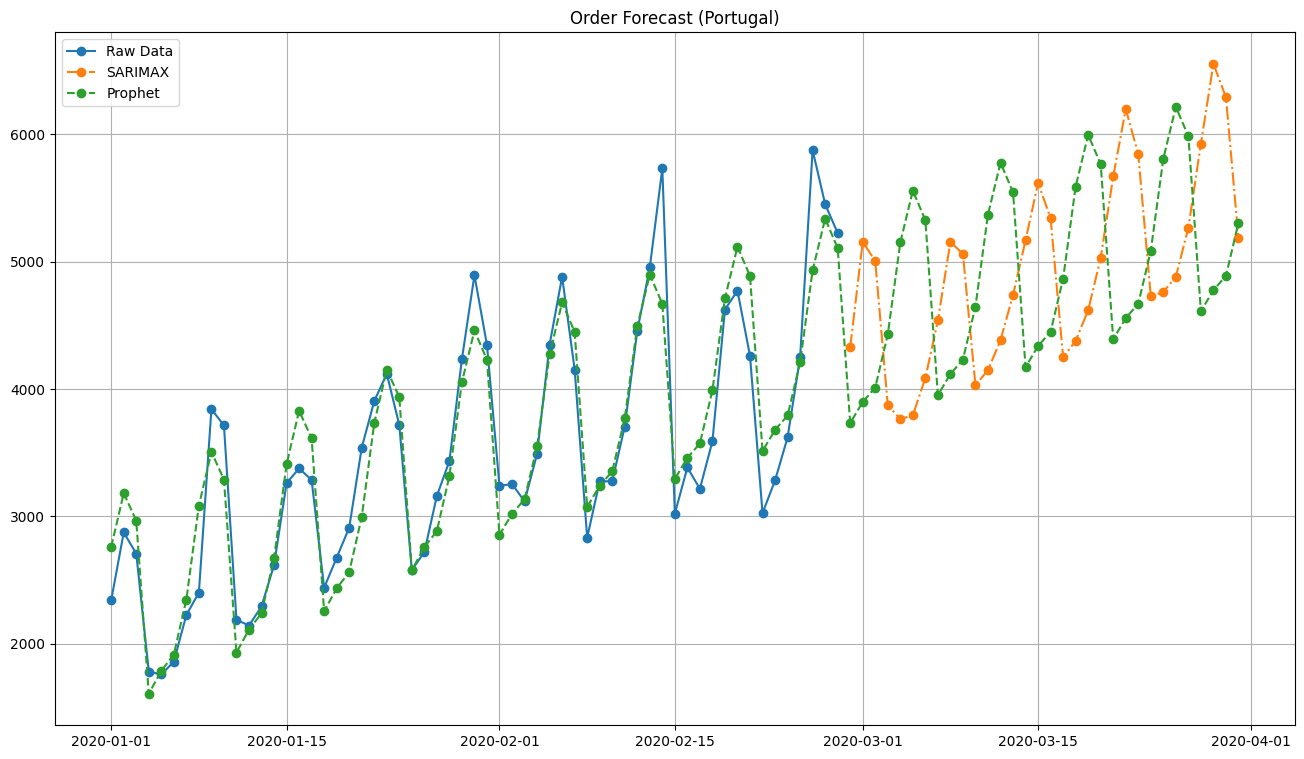

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Order Forecast (Portugal)')
plt.plot_date(forecast.index, forecast["products_in_order"], linestyle="-", label='Raw Data')
plt.plot_date(forecast.index, forecast["SARIMAX_Forecast"], linestyle="-.", label='SARIMAX')
plt.plot_date(forecast.index, forecast["Prophet_Forecast"], linestyle="--", label='Prophet')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
size = len(df_portugal)
rmse_prophet_portugal = np.sqrt(mean_squared_error(forecast['products_in_order'][:size], forecast['Prophet_Forecast'][:size]))
print('Test RMSE: %.4f' % rmse_prophet_portugal)

Test RMSE: 325.3116


The value of RMSE before tuning is already lower than SARIMAX! Imagine if we tune up this Prophet parameters!

# Ghana Order Forecast (Facebook Prophet)

## Data Preparation

In [ ]:
my_model = Prophet(interval_width=0.95)

In [ ]:
df_pr = df_ghana.reset_index()
df_pr.columns = ['ds', 'y']
df_pr

ds     y
0  2020-01-01   327
1  2020-01-02   334
2  2020-01-03   184
3  2020-01-04   452
4  2020-01-05   530
5  2020-01-06   528
6  2020-01-07   397
7  2020-01-08   435
8  2020-01-09   346
9  2020-01-10   336
10 2020-01-11   430
11 2020-01-12   518
12 2020-01-13   537
13 2020-01-14   639
14 2020-01-15   538
15 2020-01-16   472
16 2020-01-17   397
17 2020-01-18   479
18 2020-01-19   509
19 2020-01-20   619
20 2020-01-21   654
21 2020-01-22   624
22 2020-01-23   489
23 2020-01-24   462
24 2020-01-25   641
25 2020-01-26   654
26 2020-01-27   648
27 2020-01-28   717
28 2020-01-29   714
29 2020-01-30   645
30 2020-01-31   484
31 2020-02-01   591
32 2020-02-02   942
33 2020-02-03   774
34 2020-02-04   724
35 2020-02-05   704
36 2020-02-06   629
37 2020-02-07   395
38 2020-02-08   741
39 2020-02-09   997
40 2020-02-10   597
41 2020-02-11   812
42 2020-02-12   769
43 2020-02-13   832
44 2020-02-14   678
45 2020-02-15   826
46 2020-02-16   882
47 2020-02-17  1012
48 2020-02-18   928
49 2020-02-19   867
50 2020-02-20  1073
51 2020-02-21   610
52 2020-02-22   870
53 2020-02-23   795
54 2020-02-24   817
55 2020-02-25   799
56 2020-02-26   974
57 2020-02-27   967
58 2020-02-28   636

In [ ]:
start = time.time()

m = Prophet()
m.fit(df_pr)

prophet_ghana_training_time = time.time() - start
print('Prophet training time: %.3f s' % prophet_ghana_training_time)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3g77__w3/ghlo1dnh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3g77__w3/e9nsp8o4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2995', 'data', 'file=/tmp/tmp3g77__w3/ghlo1dnh.json', 'init=/tmp/tmp3g77__w3/e9nsp8o4.json', 'output', 'file=/tmp/tmp3g77__w3/prophet_modelxwk22_8h/prophet_model-20231220071911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet training time: 0.213 s


## March 2020 Forecast

In [ ]:
future = m.make_future_dataframe(periods=32)

start = time.time()

prophet_pred = m.predict(future)

prophet_ghana_forecast_time = time.time() - start
print('Prophet forecast time: %.3f s' % prophet_ghana_forecast_time)

prophet_pred = pd.DataFrame({"created_date" : prophet_pred['ds'], "Prophet_Forecast" : prophet_pred["yhat"]})
prophet_pred = prophet_pred.set_index("created_date")
prophet_pred

Prophet forecast time: 0.076 s


Prophet_Forecast
created_date                  
2020-01-01              393.89
2020-01-02              375.56
2020-01-03              197.22
2020-01-04              394.73
2020-01-05              494.36
...                        ...
2020-03-27              999.59
2020-03-28             1197.09
2020-03-29             1296.72
2020-03-30             1259.85
2020-03-31             1277.10

[91 rows x 1 columns]

In [ ]:
forecast_summary = prophet_pred.groupby(forecast.index.month).sum()
forecast_summary.index.name = 'month'
forecast_summary

Prophet_Forecast
month                  
1              15729.40
2              23181.33
3              33841.24

In [ ]:
forecast = prophet_pred.join(df_ghana).join(forecast_sarimax_ghana)
forecast

Prophet_Forecast  products_in_order  SARIMAX_Forecast
created_date                                                       
2020-01-01              393.89             327.00               NaN
2020-01-02              375.56             334.00               NaN
2020-01-03              197.22             184.00               NaN
2020-01-04              394.73             452.00               NaN
2020-01-05              494.36             530.00               NaN
...                        ...                ...               ...
2020-03-27              999.59                NaN           1067.15
2020-03-28             1197.09                NaN           1046.41
2020-03-29             1296.72                NaN            997.72
2020-03-30             1259.85                NaN            892.11
2020-03-31             1277.10                NaN           1027.69

[91 rows x 3 columns]

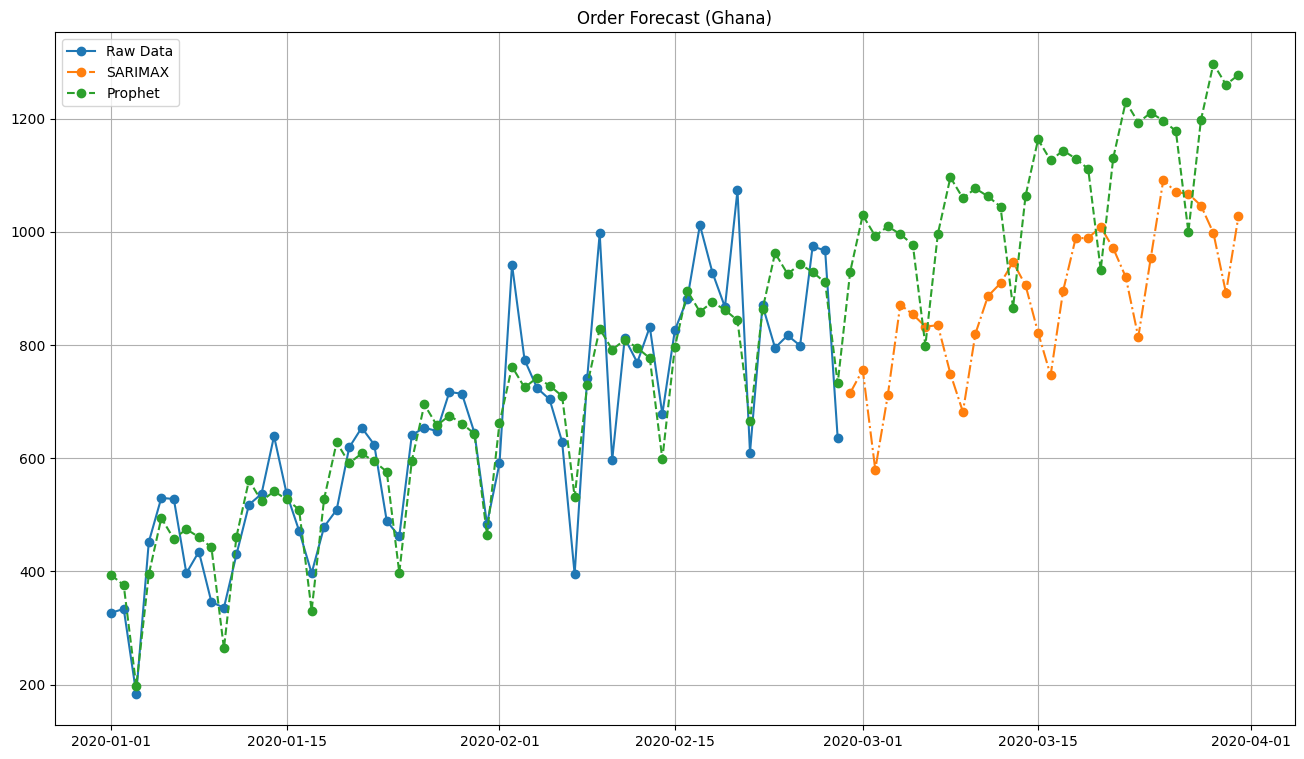

In [ ]:
plt.figure(figsize=(16,9))
plt.title('Order Forecast (Ghana)')
plt.plot_date(forecast.index, forecast["products_in_order"], linestyle="-", label='Raw Data')
plt.plot_date(forecast.index, forecast["SARIMAX_Forecast"], linestyle="-.", label='SARIMAX')
plt.plot_date(forecast.index, forecast["Prophet_Forecast"], linestyle="--", label='Prophet')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
size = len(df_ghana)
rmse_prophet_ghana = np.sqrt(mean_squared_error(forecast['products_in_order'][:size], forecast['Prophet_Forecast'][:size]))
print('Test RMSE: %.4f' % rmse_prophet_ghana)

Test RMSE: 82.0110


The value of RMSE before tuning is already lower than SARIMAX! Imagine if we tune up this Prophet parameters!

# Comparison

In [ ]:
print('\nPortugal')
print('RMSE SARIMAX: %.4f' % rmse_sarimax_portugal)
print('RMSE Prophet: %.4f' % rmse_prophet_portugal)

print('\nGhana')
print('RMSE SARIMAX: %.4f' % rmse_sarimax_ghana)
print('RMSE Prophet: %.4f' % rmse_prophet_ghana)


Portugal
RMSE SARIMAX: 569.2641
RMSE Prophet: 325.3116

Ghana
RMSE SARIMAX: 155.2347
RMSE Prophet: 82.0110


In [ ]:
print('\nPortugal')
print('Training Time SARIMAX: %.4f s' % sarimax_portugal_training_time)
print('Training Time Prophet: %.4f s' % prophet_portugal_training_time)

print('Forecast Time SARIMAX: %.4f s' % sarimax_portugal_forecast_time)
print('Forecast Time Prophet: %.4f s' % prophet_portugal_forecast_time)

print('\nGhana')
print('Training Time SARIMAX: %.4f s' % sarimax_ghana_training_time)
print('Training Time Prophet: %.4f s' % prophet_ghana_training_time)

print('Forecast Time SARIMAX: %.4f s' % sarimax_ghana_forecast_time)
print('Forecast Time Prophet: %.4f s' % prophet_ghana_forecast_time)


Portugal
Training Time SARIMAX: 73.7451 s
Training Time Prophet: 0.2935 s
Forecast Time SARIMAX: 86.4594 s
Forecast Time Prophet: 0.0619 s

Ghana
Training Time SARIMAX: 37.9348 s
Training Time Prophet: 0.2134 s
Forecast Time SARIMAX: 58.2058 s
Forecast Time Prophet: 0.0760 s
